In [1]:
import sys
# Set the path to the repository here
sys.path.append("../")
import detr_tf
from detr_tf.inference import get_model_inference, numpy_bbox_to_image
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
import tensorflow as tf
tf.autograph.set_verbosity(0)
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 1:
    print("GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
import warnings

warnings.filterwarnings("ignore")

GPU


In [3]:
from detr_tf.training_config import TrainingConfig
from os.path import expanduser
import os

class CustomConfig(TrainingConfig):

    def __init__(self):
        super().__init__()        
        # Dataset info
        self.datadir = os.path.join("../data/WIDERface/")
        # The model is trained using fixed size images.
        # The following is the desired target image size, but it can be change based on your
        # dataset
        #self.image_size = (480, 720)
        self.image_size = 376, 672
        # Batch size
        self.batch_size = 1
        # Using the target batch size , the training loop will agregate the gradient on 38 steps
        # before to update the weights
        self.target_batch = 8

config = CustomConfig()

In [4]:
def numpy_fc(idx, fc, outputs_types=(tf.float32, tf.float32, tf.int64, tf.string), **params):
    """
    Call a numpy function on each given ID (`idx`) and load the associated image and labels (bbbox and cls)
    """
    def _np_function(_idx):
        return fc(_idx, **params)
    return tf.numpy_function(_np_function, [idx], outputs_types)

def pad_labels(images: tf.Tensor, t_bbox: tf.Tensor, t_class: tf.Tensor, filename:tf.string):
    """ Pad the bbox by adding [0, 0, 0, 0] at the end
    and one header to indicate how maby bbox are set.
    Do the same with the labels. 
    """
    nb_bbox = tf.shape(t_bbox)[0]

    bbox_header = tf.expand_dims(nb_bbox, axis=0)
    bbox_header = tf.expand_dims(bbox_header, axis=0)
    bbox_header = tf.pad(bbox_header, [[0, 0], [0, 3]])
    bbox_header = tf.cast(bbox_header, tf.float32)
    cls_header = tf.constant([[0]], dtype=tf.int64)

    # print(t_bbox, t_class, nb_bbox)
    # print("here")
    # Padd bbox and class
    t_bbox = tf.pad(t_bbox, [[0, 100 - 1 - nb_bbox], [0, 0]], mode='CONSTANT', constant_values=0)#100 init for both
    t_class = tf.pad(t_class, [[0, 100 - 1 - nb_bbox], [0, 0]], mode='CONSTANT', constant_values=0)

    t_bbox = tf.concat([bbox_header, t_bbox], axis=0)
    t_class = tf.concat([cls_header, t_class], axis=0)

    return images, t_bbox, t_class,filename

In [5]:
#For loading the WIDER FACE dataset


import tensorflow as tf
from random import shuffle
import pandas as pd
import imageio

from detr_tf.inference import numpy_bbox_to_image
from detr_tf import bbox
import numpy as np

from detr_tf.data import processing
from detr_tf.data.transformation import detr_transform

# Set the class name.
CLASS_NAMES = ["head"]
# Add the background class at the begining
CLASS_NAMES = ["background"] + CLASS_NAMES

def load_wider_data_from_index(index, class_names, filenames, anns, config, augmentation):
    # Open the image
    
    #image = imageio.imread(os.path.join(config.datadir, f"{train_val}", filenames[img_id]))
    image = imageio.imread(filenames[index],as_gray=False, pilmode="RGB")
    # Select all the annotatiom (bbox and class) on this image
    image_anns = anns[anns["filename"] == filenames[index]]    
    #print(filenames[index], image.shape)
    
    # Convert all string class to number (the target class)
    t_class = image_anns["class"].map(lambda x: class_names.index(x)).to_numpy()
    # Select the width&height of each image (should be the same since all the ann belongs to the same image)
    width = image_anns["width"].to_numpy()
    height = image_anns["height"].to_numpy()
    # Select the xmin, ymin, xmax and ymax of each bbox, Then, normalized the bbox to be between and 0 and 1
    # Finally, convert the bbox from xmin,ymin,xmax,ymax to x_center,y_center,width,height
    bbox_list = image_anns[["x", "y", "w", "h"]].to_numpy()
    bbox_list = bbox_list / [width[0], height[0], width[0], height[0]] 
    t_bbox = bbox.xy_min_xy_max_to_xcycwh(bbox_list)
    
    # Transform and augment image with bbox and class if needed
    image, t_bbox, t_class = detr_transform(image, t_bbox, t_class, config, augmentation=augmentation)

    # Normalized image
    image = processing.normalized_images(image, config)
    filename = filenames[index]
            
    return image.astype(np.float32), t_bbox.astype(np.float32), np.ndarray.astype(np.expand_dims(t_class, axis=-1), np.int64), filename

#np.expand_dims(t_class, axis=-1)

In [6]:
from detr_tf.networks.detr import get_detr_model

#TransferLearning
detr = get_detr_model(config, include_top=False, nb_class=2, weights="detr")
#detr.load_weights("detr-learn-third10.ckpt")
detr.summary()

Load weights from weights/detr\detr.ckpt
(6, None, 100, 256)
Model: "detr_finetuning"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
detr (Model)                    (6, None, 100, 256)  41449152    input_2[0][0]                    
__________________________________________________________________________________________________
pos_layer (Sequential)          (6, None, 100, 4)    132612      detr[1][0]                       
__________________________________________________________________________________________________
cls_layer (Dense)               (6, None, 100, 2)    514         detr[1][0]                       
_______________________

## Testing

In [7]:
#detr.load_weights("detr-learn-third10.ckpt")
detr.load_weights("detr-transfolearn-third.ckpt")

In [8]:
from detr_tf import bbox
import torch

def nms(boxes, scores, overlap=0.4, top_k=100):
    """Apply non-maximum suppression at test time to avoid detecting too many
    overlapping bounding boxes for a given object.
    Args:
        boxes: (tensor) The location preds for the img, Shape: [num_priors,4].
        scores: (tensor) The class predscores for the img, Shape:[num_priors].
        overlap: (float) The overlap thresh for suppressing unnecessary boxes.
        top_k: (int) The Maximum number of box preds to consider.
    Return:
        The indices of the kept boxes with respect to num_priors.
    """

    scores = np.array(scores)
    scores = torch.tensor(scores)
    #boxes = boxes.numpy()
    boxes = torch.tensor(boxes)
    #print(scores.numpy().shape)
    keep = scores.new(scores.size(0)).zero_().long()
    #keep = tf.fill(scores.shape, 0.0)
    #keep = tf.fill(tf.shape(Y), 0.0)
    #print(tf.size(boxes).numpy())
    #if tf.size(boxes).numpy() == 0:
    count = 0
    if scores.numpy().shape[0] == 0:
        return keep, count
    if boxes.numel() ==0:
        return keep, count
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    #area = (x2-x1)*(y2-y1)
    v, idx = scores.sort(0)  # sort in ascending order
    #idx = np.argsort(scores)
    # I = I[v >= 0.01]
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    # keep = torch.Tensor()
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        # keep.append(i)
        keep[count] = i
        count += 1
        if idx.size(0) == 1:
            break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w * h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter / union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep.numpy(), count

def boxes_output(image, bbox_list, labels=None, scores=None, class_name=[], config=None):
    """ Numpy function used to display the bbox (target or prediction)
    """
    assert(image.dtype == np.float32 and image.dtype == np.float32 and len(image.shape) == 3)

    if config is not None and config.normalized_method == "torch_resnet":
        channel_avg = np.array([0.485, 0.456, 0.406])
        channel_std = np.array([0.229, 0.224, 0.225])
        image = (image * channel_std) + channel_avg
        image = (image*255).astype(np.uint8)
    elif config is not None and config.normalized_method == "tf_resnet":
        image = image + mean
        image = image[..., ::-1]
        image = image  / 255
        
    bbox_xcycwh = bbox.np_rescale_bbox_xcycwh(bbox_list, (image.shape[0], image.shape[1])) 
    #print(image.shape, bbox_list.shape)
    bbox_x1y1x2y2 = bbox.np_xcycwh_to_xy_min_xy_max(bbox_xcycwh)

    if scores is not None:
        keep, count = nms(bbox_x1y1x2y2, scores)
        if count!=0:
            bbox_x1y1x2y2 = bbox_x1y1x2y2[keep]

    # Set the labels if not defined
    if labels is None: labels = np.zeros((bbox_x1y1x2y2.shape[0]))

    return bbox_x1y1x2y2

def xy_min_xy_max_to_xywh(box: np.array) -> np.array:
    # convert the bbox from [xmin, ymin, xmax, ymax] to [x_center, y_center, w, h]
    #bbox_xcycwh = np.concatenate([bbox[:, :2] + ((bbox[:, 2:] - bbox[:, :2]) / 2), bbox[:, 2:] - bbox[:, :2]], axis=-1)
    
    bbox_xcycwh = np.zeros((box.shape[0],box.shape[1]))
    bbox_xcycwh[:,0] = box[:,0]
    bbox_xcycwh[:,1] = box[:,1]
    bbox_xcycwh[:,2] = box[:,2]-box[:,0]
    bbox_xcycwh[:,3] = box[:,3]-box[:,1]
    
    return bbox_xcycwh

In [11]:
from PIL import Image
import cv2
import glob

IMG_DIR = '../../auditoires/fullres/'
IMG_DIR_2 = '../../auditoires/misc/'

In [12]:
paths = []
w=[]
h=[]

transformation = []
names = []
clas = []
width = []
height = []
length=0

for filename in os.listdir(IMG_DIR):
    f = os.path.join(IMG_DIR, filename)
    # checking if it is a file
    if os.path.isfile(f) and f[-4:]!='json':
        #print(f)
        names.append(f)
        transformation.append([0,0,0,0])
        #img = cv2.imread(img_file, cv2.IMREAD_COLOR)
        img = Image.open(f)
        if img.mode == 'L':
            img = img.convert('RGB')
        img = np.array(img)
        width, height = img.shape[0], img.shape[1]
        w.append(width)
        h.append(height)
        clas.append("head")
        
for filename in os.listdir(IMG_DIR_2):
    f = os.path.join(IMG_DIR_2, filename)
    # checking if it is a file
    if os.path.isfile(f) and f[-4:]!='json':
        #print(f)
        names.append(f)
        transformation.append([0,0,0,0])
        #img = cv2.imread(img_file, cv2.IMREAD_COLOR)
        img = Image.open(f)
        if img.mode == 'L':
            img = img.convert('RGB')
        img = np.array(img)
        width, height = img.shape[0], img.shape[1]
        w.append(width)
        h.append(height)
        clas.append("head")

In [13]:
print(names, len(names))
print(w, len(w))
print(h, len(h))

['../../auditoires/fullres/auditoire_big.jpg', '../../auditoires/fullres/LISABA2.jpg', '../../auditoires/fullres/LISAPhoto.jpg', '../../auditoires/fullres/UB2.147_01.jpg', '../../auditoires/fullres/UB2.147_02.jpg', '../../auditoires/fullres/UB4.132-01.jpg', '../../auditoires/fullres/UB4.132-02.jpg', '../../auditoires/fullres/UB4.132-03.jpg', '../../auditoires/fullres/UB4.136-Coin01.jpg', '../../auditoires/fullres/UB4.136-Coin02.jpg', '../../auditoires/fullres/UB4.136-Fen01.jpg', '../../auditoires/fullres/UB4.136-Fen02.jpg', '../../auditoires/misc/auditoire.jpg', '../../auditoires/misc/auditoire_big.jpg', '../../auditoires/misc/auditoire_big2.jpg', '../../auditoires/misc/auditoire_big_central.jpg', '../../auditoires/misc/auditoire_big_cote.jpg', '../../auditoires/misc/ba2.jpg', '../../auditoires/misc/cinema.jpg', '../../auditoires/misc/cinema2.jpg', '../../auditoires/misc/cinema2_h.jpg', '../../auditoires/misc/cmu.jpg', '../../auditoires/misc/Ds7SFxYXQAAfc63.jpg', '../../auditoires/misc

In [14]:
df = pd.DataFrame(list(zip(names, w, h,clas,np.asarray(transformation)[:,0]+np.asarray(transformation)[:,2]/2,
                           np.asarray(transformation)[:,1]+np.asarray(transformation)[:,3]/2,
                          np.asarray(transformation)[:,2],np.asarray(transformation)[:,3])),
                  columns =['filename','width','height','class','x','y','w','h'])
df

filename  width  height class    x  \
0        ../../auditoires/fullres/auditoire_big.jpg   2464    3280  head  0.0   
1              ../../auditoires/fullres/LISABA2.jpg   2464    3280  head  0.0   
2            ../../auditoires/fullres/LISAPhoto.jpg   2464    3280  head  0.0   
3           ../../auditoires/fullres/UB2.147_01.jpg   2464    3280  head  0.0   
4           ../../auditoires/fullres/UB2.147_02.jpg   2464    3280  head  0.0   
5           ../../auditoires/fullres/UB4.132-01.jpg   2464    3280  head  0.0   
6           ../../auditoires/fullres/UB4.132-02.jpg   2464    3280  head  0.0   
7           ../../auditoires/fullres/UB4.132-03.jpg   2464    3280  head  0.0   
8       ../../auditoires/fullres/UB4.136-Coin01.jpg   2464    3280  head  0.0   
9       ../../auditoires/fullres/UB4.136-Coin02.jpg   2464    3280  head  0.0   
10       ../../auditoires/fullres/UB4.136-Fen01.jpg   2464    3280  head  0.0   
11       ../../auditoires/fullres/UB4.136-Fen02.jpg   2464    3280  head  0.0   
12              ../../auditoires/misc/auditoire.jpg    385     512  head  0.0   
13          ../../auditoires/misc/auditoire_big.jpg   2464    3280  head  0.0   
14         ../../auditoires/misc/auditoire_big2.jpg   1232    1640  head  0.0   
15  ../../auditoires/misc/auditoire_big_central.jpg    457    1055  head  0.0   
16     ../../auditoires/misc/auditoire_big_cote.jpg    459     713  head  0.0   
17                    ../../auditoires/misc/ba2.jpg   2464    3280  head  0.0   
18                 ../../auditoires/misc/cinema.jpg    576    1024  head  0.0   
19                ../../auditoires/misc/cinema2.jpg   1134    2016  head  0.0   
20              ../../auditoires/misc/cinema2_h.jpg   3402    6048  head  0.0   
21                    ../../auditoires/misc/cmu.jpg   2848    4288  head  0.0   
22        ../../auditoires/misc/Ds7SFxYXQAAfc63.jpg    800    1200  head  0.0   
23              ../../auditoires/misc/LISABA2_2.jpg   1232    1640  head  0.0   
24              ../../auditoires/misc/LISABA2_3.jpg    862    1148  head  0.0   
25                  ../../auditoires/misc/obama.jpg   1128    1500  head  0.0   
26               ../../auditoires/misc/olivier3.jpg   1536    2048  head  0.0   
27                  ../../auditoires/misc/stock.jpg    513     770  head  0.0   
28               ../../auditoires/misc/testcrop.jpg    934    1364  head  0.0   
29                  ../../auditoires/misc/trump.jpg    500    1500  head  0.0   
30                   ../../auditoires/misc/yvon.jpg    800    1200  head  0.0   

      y  w  h  
0   0.0  0  0  
1   0.0  0  0  
2   0.0  0  0  
3   0.0  0  0  
4   0.0  0  0  
5   0.0  0  0  
6   0.0  0  0  
7   0.0  0  0  
8   0.0  0  0  
9   0.0  0  0  
10  0.0  0  0  
11  0.0  0  0  
12  0.0  0  0  
13  0.0  0  0  
14  0.0  0  0  
15  0.0  0  0  
16  0.0  0  0  
17  0.0  0  0  
18  0.0  0  0  
19  0.0  0  0  
20  0.0  0  0  
21  0.0  0  0  
22  0.0  0  0  
23  0.0  0  0  
24  0.0  0  0  
25  0.0  0  0  
26  0.0  0  0  
27  0.0  0  0  
28  0.0  0  0  
29  0.0  0  0  
30  0.0  0  0

In [16]:
def load_audit(df, config, augmentation=False):
    """ Load the hardhat dataset
    """
    print(df.head)

    anns = df

    unique_class = anns["class"].unique()
    unique_class.sort()


    # Set the background class to 0
    config.background_class = 0
    class_names = ["background"] + unique_class.tolist()


    filenames = anns["filename"].unique().tolist()
    indexes = list(range(0, len(filenames)))
    #shuffle(indexes)

    dataset = tf.data.Dataset.from_tensor_slices(indexes)
    dataset = dataset.map(lambda idx: numpy_fc(
        idx, load_wider_data_from_index, 
        class_names=class_names, filenames=filenames, anns=anns, config=config, augmentation=False)
    ,num_parallel_calls=tf.data.experimental.AUTOTUNE)


    # Filter labels to be sure to keep only sample with at least one bbox
    dataset = dataset.filter(lambda imgs, tbbox, tclass, filename: tf.shape(tbbox)[0] > 0)
    # Pad bbox and labels
    dataset = dataset.map(pad_labels, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Batch images
    dataset = dataset.batch(1, drop_remainder=True)
    
    return dataset

In [17]:
dataset = load_audit(df, config)

<bound method NDFrame.head of                                            filename  width  height class    x  \
0        ../../auditoires/fullres/auditoire_big.jpg   2464    3280  head  0.0   
1              ../../auditoires/fullres/LISABA2.jpg   2464    3280  head  0.0   
2            ../../auditoires/fullres/LISAPhoto.jpg   2464    3280  head  0.0   
3           ../../auditoires/fullres/UB2.147_01.jpg   2464    3280  head  0.0   
4           ../../auditoires/fullres/UB2.147_02.jpg   2464    3280  head  0.0   
5           ../../auditoires/fullres/UB4.132-01.jpg   2464    3280  head  0.0   
6           ../../auditoires/fullres/UB4.132-02.jpg   2464    3280  head  0.0   
7           ../../auditoires/fullres/UB4.132-03.jpg   2464    3280  head  0.0   
8       ../../auditoires/fullres/UB4.136-Coin01.jpg   2464    3280  head  0.0   
9       ../../auditoires/fullres/UB4.136-Coin02.jpg   2464    3280  head  0.0   
10       ../../auditoires/fullres/UB4.136-Fen01.jpg   2464    3280  head  0.0  

Done predictions with time 4.226 s
(36,)


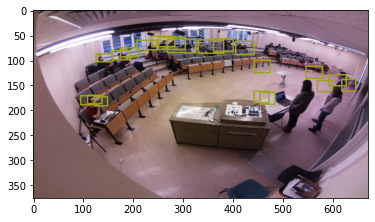

Done predictions with time 0.485 s
(55,)


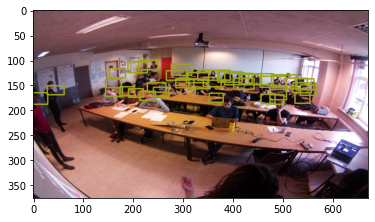

Done predictions with time 0.485 s
(12,)


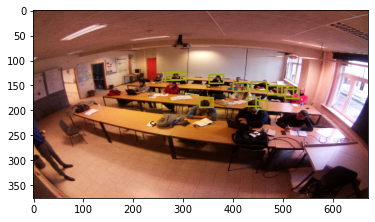

Done predictions with time 0.529 s
(20,)


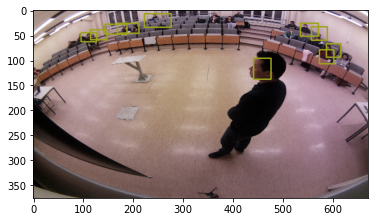

Done predictions with time 0.484 s
(86,)


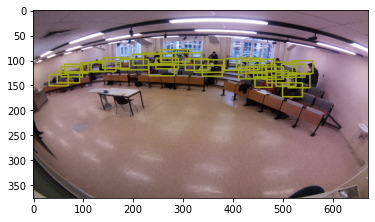

Done predictions with time 0.483 s
(25,)


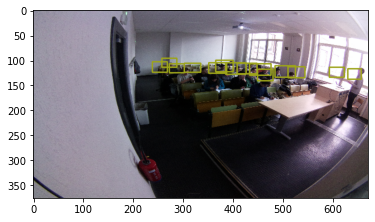

Done predictions with time 0.506 s
(36,)


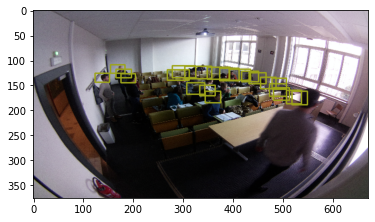

Done predictions with time 0.274 s
(48,)


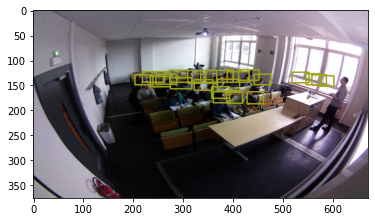

Done predictions with time 0.290 s
(20,)


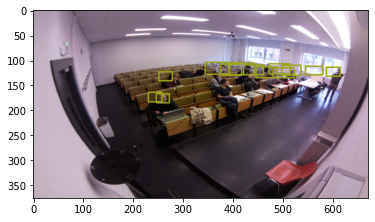

Done predictions with time 0.269 s
(28,)


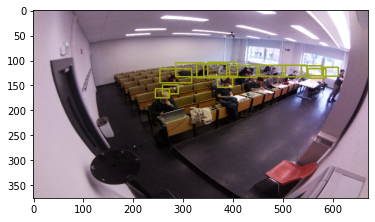

Done predictions with time 0.287 s
(17,)


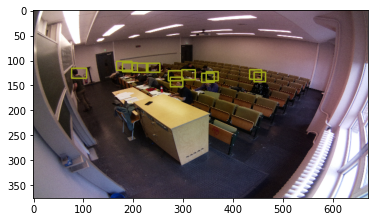

Done predictions with time 0.289 s
(20,)


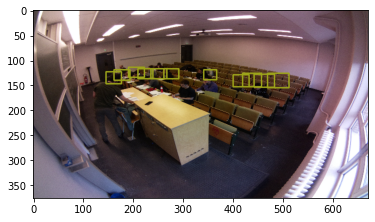

Done predictions with time 0.285 s
(35,)


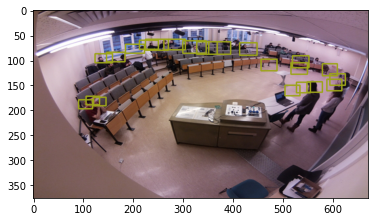

Done predictions with time 0.273 s
(36,)


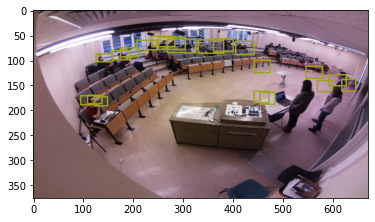

Done predictions with time 0.293 s
(30,)


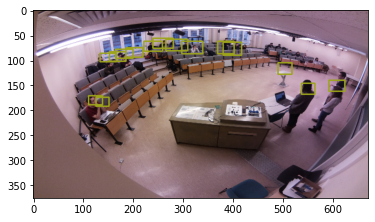

Done predictions with time 0.285 s
(26,)


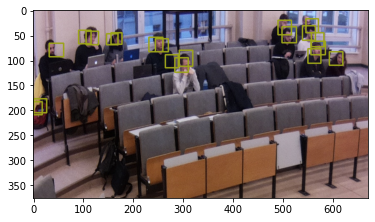

Done predictions with time 0.294 s
(14,)


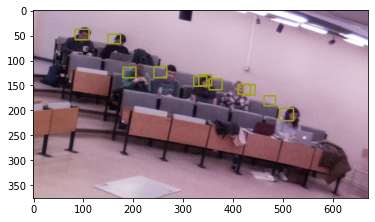

Done predictions with time 0.291 s
(58,)


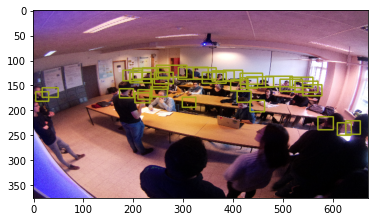

Done predictions with time 0.298 s
(100,)


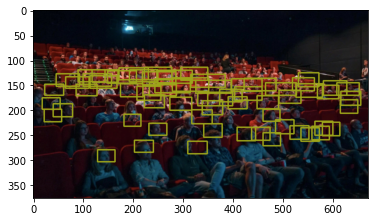

Done predictions with time 0.298 s
(100,)


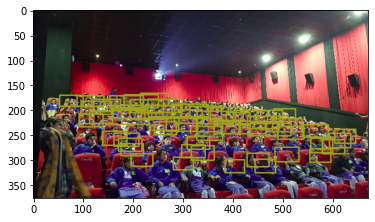

Done predictions with time 0.286 s
(100,)


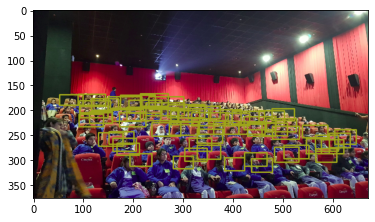

Done predictions with time 0.294 s
(100,)


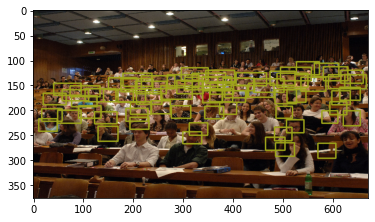

Done predictions with time 0.297 s
(100,)


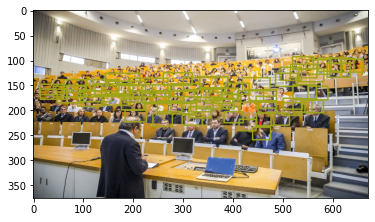

Done predictions with time 0.306 s
(51,)


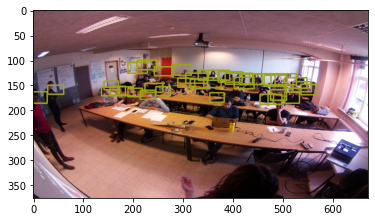

Done predictions with time 0.289 s
(46,)


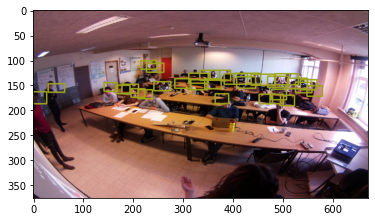

Done predictions with time 0.303 s
(75,)


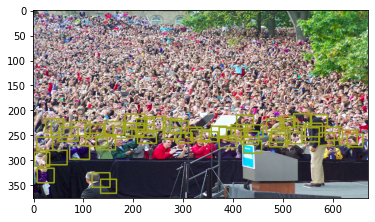

Done predictions with time 0.279 s
(77,)


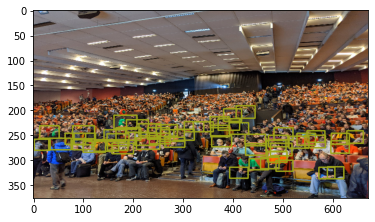

Done predictions with time 0.271 s
(34,)


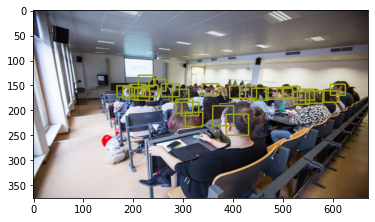

Done predictions with time 0.274 s
(22,)


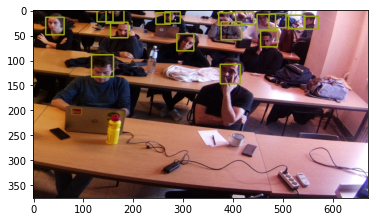

Done predictions with time 0.302 s
(94,)


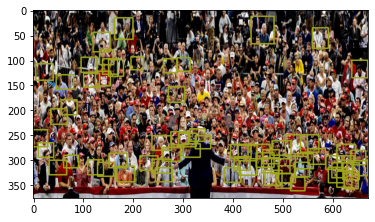

Done predictions with time 0.271 s
(100,)


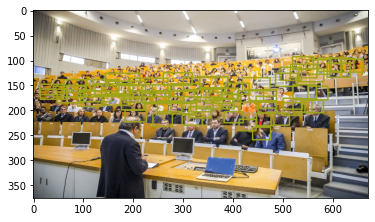

In [21]:
i=0

box = []
scores =[]

f_names = []

for valid_images, target_bbox, target_class, filename in dataset:
    
    #print(filename.numpy()[0].decode("utf-8"))
    start = time.time()
    m_outputs = detr(valid_images, training=False)
    predicted_bbox, predicted_labels, predicted_scores = get_model_inference(m_outputs, config.background_class, bbox_format="xy_center")
    now=(time.time()-start)
    print("Done predictions with time %.3f s"%now)
    #print(predicted_scores)
    
    result = numpy_bbox_to_image(
        np.array(valid_images[0]),
        np.array(predicted_bbox),
        np.array(predicted_labels),
        scores=np.array(predicted_scores),
        class_name=['head','background'], 
        config=config
    )
    
    
    plt.imshow(result)
    plt.savefig("audit%i_detr.jpg"%i)
    plt.show()
    i+=1
    #if i>20:
    #    break